In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
import innvestigate
tf.compat.v1.disable_eager_execution()

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

2023-10-27 17:21:40.632607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Running on GPU


2023-10-27 17:22:01.460226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-10-27 17:22:01.514956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-10-27 17:22:01.517166: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


In [2]:
### Sverdrup 
# mainDir  = '/scratch2/pillarh/eccov4r4'
# gridDir  = mainDir + '/GRID'
# thetaDir = mainDir + '/eccov4r4_nctiles_daily/THETA'

### Lonestar6
mainDir  = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
gridDir  = mainDir
thetaDir = mainDir

In [3]:
# %%capture --no-stderr --no-stdout --no-display 

# #### https://stackoverflow.com/questions/72821108/hdf5-warnings-when-accessing-xarray-dataset
# #### Necessary to suppress stderr output that crashes the file
# from dask.distributed import Client
# c = Client(threads_per_worker=1)

# #### Write thetaSurf data year-wise to netcdf file in scracth2
# #### I did it manually one year at a time in list `years` since stderr output crashes the file

# def subset(ds):
#     dict_subset = {'k':0}
#     ds_subset = ds.isel(dict_subset); # ; at the end to suppress output
#     return ds_subset; # ; at the end to suppress output

# years = np.arange(1992,2018)

# # for year in years:
# #     ds = xr.open_mfdataset(join(thetaDir,f'{year}/*/*.nc'), preprocess=subset); # ; at the end to suppress output
# #     ds.to_netcdf(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4_{year}.nc', mode='w')

# for year in years:
#     print(year)
#     ds = xr.open_mfdataset(join(saltDir,f'{year}/*/*.nc'), preprocess=subset); # ; at the end to suppress output
#     ds.to_netcdf(f'/scratch2/shreyas/LRP_eccov4r4_data/saltSurfECCOv4r4_{year}.nc', mode='w')

In [4]:
### Sverdrup  - /scratch2/shreyas/LRP_eccov4r4_data
### Lonestar6 - /work/07665/shrey911/ls6/LRP_eccov4r4_data

ds = xr.open_dataset(f'/work/07665/shrey911/ls6/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')

In [5]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds['XC'].data
YC = ds['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds['tile'].data,
        j    = ds['j'].data,
        i    = ds['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

ds = ds.assign(hFacC_mask   = da_hFacC_mask,
          latMask      = da_latMask,
          maskFinal    = da_maskFinal,
          NaNmaskFinal = da_NaNmaskFinal)

wetpoints = np.nonzero(ds['maskFinal'].data)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r4_data/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


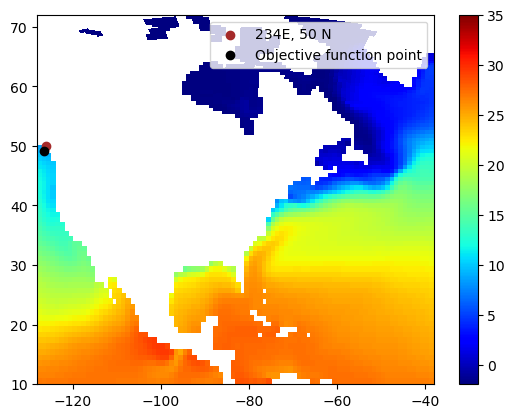

In [6]:
plt.pcolor(ds['XC'].isel(tile = 10), ds['YC'].isel(tile = 10), 
           ds['NaNmaskFinal'].isel(tile = 10)*ds['THETA'].isel(time = 0, tile = 10), 
           cmap = 'jet', vmax = 35)
plt.colorbar()
plt.scatter(-126.0, 50.0, color = 'brown', label = '234E, 50 N')
plt.scatter(ds['XC'].isel(tile = 10, j = 1, i = 43),
            ds['YC'].isel(tile = 10, j = 1, i = 43),
            color = 'black', label = 'Objective function point')
plt.legend()

Text(0.5, 1.0, 'MaskedTheta 1992_01_01')

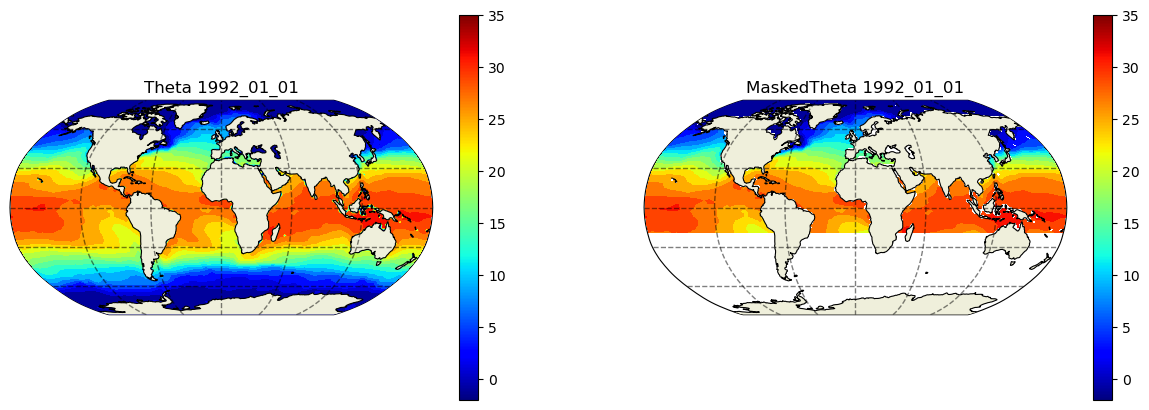

In [7]:
plt.figure(figsize=(15,5))

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              ds['THETA'].isel(time = 0),
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmax = 35,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [1,2,1]);
P[1].set_title("Theta 1992_01_01")

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'],
                              ds['NaNmaskFinal']*ds['THETA'].isel(time = 0),
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', cmax = 35,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [1,2,2]);
P[1].set_title("MaskedTheta 1992_01_01")

In [8]:
X_2d = ds['THETA'].transpose("time","j","i","tile").data

### X_2d is transposed, so order of wetpoint array changes, note in next line
X    = ds['THETA'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]]
y    = ds['THETA'].isel(tile = 10, j = 1, i = 43).data

yOrig = np.copy(y)
y = y - np.mean(y)
scipy.signal.detrend(y, axis=0, type='linear', bp=0, overwrite_data=True)
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

X = X[30:-30]
X = X - np.mean(X, axis = 0)
scipy.signal.detrend(X, axis=0, type='linear', bp=0, overwrite_data=True)

array([[-8.86728540e-02,  3.58070672e-01,  6.19491875e-01, ...,
        -1.18389940e+00, -1.31833529e+00, -1.04089701e+00],
       [ 4.77505028e-02,  4.71105784e-01,  7.05470383e-01, ...,
        -1.00220191e+00, -1.17876601e+00, -9.33430254e-01],
       [ 2.04500481e-01,  5.90469480e-01,  7.97479868e-01, ...,
        -8.15823853e-01, -9.79384124e-01, -7.80898571e-01],
       ...,
       [-7.12096021e-02, -5.91815040e-02, -6.57344013e-02, ...,
        -5.65502755e-02, -1.02999434e-01,  1.59812234e-02],
       [ 1.37670897e-03, -5.43823652e-03, -2.18034238e-02, ...,
        -3.64567377e-02, -3.33382227e-02,  1.01814836e-01],
       [ 3.89860570e-02,  3.73854637e-02,  2.34779529e-02, ...,
         5.22798672e-03,  6.42206520e-04,  1.17419869e-01]], dtype=float32)

In [35]:
def quickSetup(X, y_oneHot, y, 
               numVars, 
               lrp_methods, 
               lagSteps,
               decay_func = None,
               **NNkwargs):
    
    result = {}
    
    if lagSteps > 0:
        K = TrainFullyConnectedNN(X[:-lagSteps], y_oneHot[lagSteps:], **NNkwargs)
        L = TrainLR(X[:-lagSteps], y[lagSteps:], y_ref = 0.0, fit_intercept = False)
    elif lagSteps == 0:
        K = TrainFullyConnectedNN(X, y_oneHot, **NNkwargs)
        L = TrainLR(X, y, y_ref = 0.0, fit_intercept = False)
    else:
        K = TrainFullyConnectedNN(X[-lagSteps:], y_oneHot[:lagSteps], **NNkwargs)
        L = TrainLR(X[-lagSteps:], y[:lagSteps], y_ref = 0.0, fit_intercept = False)
        
    best_model = K.quickTrain(decay_func)
    result['cost_predict_NN'] = best_model.predict(X)
    
    regr = L.quickTrain()
    result['cost_predict_LR'] = regr.predict(X)
        
    pred_NN = result['cost_predict_NN'].copy()
    pred_NN[:,0] = pred_NN[:,0] > 0.5
    pred_NN[:,1] = pred_NN[:,1] >= 0.5

    idx_NN_pos = []
    idx_NN_neg = []

    if lagSteps >= 0:
        for i in range(len(oneHotCost[lagSteps:,0])):
            if oneHotCost[lagSteps+i,0] == 1 and pred_NN[i,0] == 1:
                idx_NN_pos.append(i)
            if oneHotCost[lagSteps+i,0] == 0 and pred_NN[i,0] == 0:
                idx_NN_neg.append(i)
    else:
        for i in range(len(oneHotCost[:lagSteps,0])):
            if oneHotCost[i,0] == 1 and pred_NN[i-lagSteps,0] == 1:
                idx_NN_pos.append(i)
            if oneHotCost[i,0] == 0 and pred_NN[i-lagSteps,0] == 0:
                idx_NN_neg.append(i)        
    
    normalizeDict = {'bool_': True, 'kind': 'MaxAbs'}
    kwargs = {'y_ref': 0.00}

    # Create model without trailing softmax
    model_wo_softmax = innvestigate.model_wo_softmax(best_model)
    
    for method in lrp_methods:

        title = method['title']
        
        print(f'Analyze using {title}')

        Xplain = XAIR(model_wo_softmax, method, 'classic', X, 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, a.shape[0], 13, 90, 90))
        rel[:,:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a[:,numvar*perVar:(numvar+1)*perVar].T
        result[method['name']+'_all'] = rel
        
        Xplain = XAIR(model_wo_softmax, method, 'classic', X[idx_NN_pos], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, a.shape[0], 13, 90, 90))
        rel[:,:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a[:,numvar*perVar:(numvar+1)*perVar].T
        result[method['name']+'_pos'] = rel

        Xplain = XAIR(model_wo_softmax, method, 'classic', X[idx_NN_neg], 
                      normalizeDict, **kwargs)
        a, _  = Xplain.quick_analyze()
        perVar = int(a.shape[1]/numVars)
        
        rel = np.zeros((numVars, a.shape[0], 13, 90, 90))
        rel[:,:,:,:,:] = np.nan
        
        for numvar in range(numVars):
            rel[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a[:,numvar*perVar:(numvar+1)*perVar].T
        result[method['name']+'_neg'] = rel
        
    print(f'Analyze using LRP-LR')

    XL = XLR(regr, X)

    a_LR, _ = XL.quick_analyze()
    perVar = int(a_LR.shape[1]/numVars)

    rel_LR = np.zeros((numVars, a_LR.shape[0], 13, 90, 90))
    rel_LR[:,:,:,:,:] = np.nan

    for numvar in range(numVars):
        rel_LR[numvar,:,wetpoints[0],wetpoints[1],wetpoints[2]] = a_LR[:,numvar*perVar:(numvar+1)*perVar].T
    result['lrp.LR'] = rel_LR
        
    return result

In [36]:
Layers = [{'size': X.shape[1], 'activation': None     , 'use_bias': None},
          {'size': 2000      , 'activation': 'relu'   , 'use_bias': True, 'l2_w_reg': 10  , 'l2_b_reg': 10},
          {'size': 400        , 'activation': 'relu'   , 'use_bias': True, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01},
          {'size': 2         , 'activation': 'softmax', 'use_bias': True, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01}]
Losses = [{'kind': 'categorical_crossentropy', 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [-60,0,60,120,180]

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.8
    epochs_drop = 2.0
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    return lrate


methods = \
[dict(name='gradient',                     optParams = {"postprocess": "abs"}, title = 'Gradient'),
 dict(name='lrp.z',                        optParams = {}                    , title = 'LRP-Z'),
 dict(name='lrp.epsilon',                  optParams = {"epsilon": 1}        , title = 'LRP-Epsilon'),
 dict(name='lrp.alpha_1_beta_0',           optParams = {}                    , title = 'LRP-Alpha-1-Beta-0')
]

In [37]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')

    adam = keras.optimizers.Adam()
    NNkwargs = {'losses': Losses, 'optimizer': adam, 'metrics': ['accuracy'],
            'batch_size': 10, 'epochs': 100, 'validation_split': 0.1,
            'filename': 'model', 'dirname': os.path.abspath('')}
    
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(X, oneHotCost, y,
                                                        numVars = 1,
                                                        lrp_methods = methods,
                                                        lagSteps = lagStepsList[i],
                                                        decay_func = step_decay,
                                                        layers = Layers, **NNkwargs)

Lag: -60 days, for Theta


2023-10-27 19:57:33.695498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-10-27 19:57:33.697394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-10-27 19:57:33.699237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 840537.12260, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 840537.12260 to 1521.20181, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 1521.20181

Epoch 4: val_loss improved from 1521.20181 to 457.23329, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 5: val_loss did not improve from 457.23329

Epoch 6: val_loss did not improve from 457.23329

Epoch 7: val_loss improved from 457.23329 to 355.98531, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 8: val_loss improved from 355.98531 to 214.10870, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 9: val_loss did not improve from 214.10870

Epoch 10: val_loss did not improve from 214.10870

Epoch 11: val_loss did not improve from 214.10870

Epoch 12: val_loss did not improve from 214.10870

Epoch 13: val_loss improved from 214.10870 to 11

KeyboardInterrupt: 

In [ ]:
subplot_idx = 1
for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    
    for lag in lagStepsList:

        field = np.nanmean(LRPDict_theta[f'LRP{lag}'][method['name']+'_pos'], axis=(0,1))
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='RdBu_r', cmin = -0.5, cmax = 0.5,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [2,3,subplot_idx])

        P[1].set_title(f"{method['title']} lag {lag} days")
        subplot_idx += 1
        
    subplot_idx = 1
    plt.show()

In [ ]:
subplot_idx = 1
for method in methods:
    plt.rcParams["figure.figsize"] = (20,10)
    for lag in lagStepsList:

        field = np.nanmean(LRPDict_theta[f'LRP{lag}'][method['name']+'_neg'], axis=(0,1))
        field = field / np.nanmax(np.abs(field))
        
        P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      field,
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='RdBu_r', cmin = -0.5, cmax = 0.5,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [2,3,subplot_idx])
        P[1].set_title(f"{method['title']} lag {lag} days")
        
        subplot_idx += 1
        
    subplot_idx = 1
    plt.show()

In [ ]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:

    field = LRPDict_theta[f'LRP{lag}']['lrp.LR'][0,0].copy()
    field = np.nanmean(LRPDict_theta[f'LRP{lag}']['lrp.LR'], axis=(0,1))
    # field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -0.5, cmax = 0.5,
                                  user_lon_0 = -150,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,subplot_idx])
    
    P[1].set_title(f"LRP-LR lag {lag} days")
    subplot_idx += 1

In [11]:
Layers = [{'size': X.shape[1], 'activation': None    , 'use_bias': None},
          {'size': 10000      , 'activation': 'relu'  , 'use_bias': True},
          {'size': 3000       , 'activation': 'relu'  , 'use_bias': True},
          {'size': 100       , 'activation': 'relu'  , 'use_bias': True},
          {'size': 2         , 'activation': 'softmax', 'use_bias': False}]
Losses = [{'kind': 'categorical_crossentropy', 'weight': 1.0}]

LRPDict_theta = {}
lagStepsList = [-60,0,60,120,180]

NNkwargs = {'losses': Losses, 'optim': 'adam', 'metrics': ['accuracy'],
            'batch_size': 10, 'epochs': 40, 'validation_split': 0.1,
            'filename': 'model', 'dirname': os.path.abspath('')}

methods = \
[dict(name='gradient',                     optParams = {"postprocess": "abs"}, title = 'Gradient'),
 # dict(name='guided_backprop',              optParams = {}                    , title = 'Guided Backprop'),
 dict(name='lrp.z',                        optParams = {}                    , title = 'LRP-Z'),
 dict(name='lrp.epsilon',                  optParams = {"epsilon": 1}        , title = 'LRP-Epsilon'),
 dict(name='lrp.alpha_1_beta_0',           optParams = {}                    , title = 'LRP-Alpha-1-Beta-0')
 # dict(name='lrp.sequential_preset_a_flat', optParams = {"epsilon": 1}        , title = 'LRP-PresetAFlat'),
 # dict(name='lrp.sequential_preset_b_flat', optParams = {"epsilon": 1}        , title = 'LRP-PresetBFlat'),
]

In [12]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    
    ### This is just a hack to automate stuff, it has no deep meaning
    ### It ensures X and y have the same size after the appropriate time lag
    Xi = (lagStepsList[i]>0)*0+(lagStepsList[i]<=0)*(30-lagStepsList[i])
    Xf = -29-lagStepsList[i] if lagStepsList[i]>=0 else None
    yi = lagStepsList[i]-30 if lagStepsList[i]>0 else 0
    yf = lagStepsList[i]+29 if lagStepsList[i]<0 else None
    
    LRPDict_theta[f'LRP{lagStepsList[i]}'] = quickSetup(X[Xi:Xf], oneHotCost[yi:yf], X, numVars = 1, 
                                                        lrp_methods = methods,
                                                        layers = Layers, **NNkwargs)

Lag: -60 days, for Theta


2023-10-25 08:08:44.723074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-10-25 08:08:44.724841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-10-25 08:08:44.726591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.35748, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 0.35748

Epoch 3: val_loss did not improve from 0.35748

Epoch 4: val_loss did not improve from 0.35748

Epoch 5: val_loss did not improve from 0.35748

Epoch 6: val_loss did not improve from 0.35748

Epoch 7: val_loss did not improve from 0.35748

Epoch 8: val_loss did not improve from 0.35748

Epoch 9: val_loss did not improve from 0.35748

Epoch 10: val_loss did not improve from 0.35748

Epoch 11: val_loss did not improve from 0.35748

Epoch 12: val_loss did not improve from 0.35748

Epoch 13: val_loss did not improve from 0.35748

Epoch 14: val_loss did not improve from 0.35748

Epoch 15: val_loss did not improve from 0.35748

Epoch 16: val_loss did not improve from 0.35748

Epoch 17: val_loss did not improve from 0.35748

Epoch 18: val_loss did not improve from 0.35748

Epoch 19: val_loss did not improve from 0.35748

Epoch 20: val_

2023-10-25 08:23:32.773842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-10-25 08:23:32.775625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-10-25 08:23:32.777381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.15692, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 0.15692 to 0.13594, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 0.13594

Epoch 4: val_loss did not improve from 0.13594

Epoch 5: val_loss did not improve from 0.13594

Epoch 6: val_loss did not improve from 0.13594

Epoch 7: val_loss did not improve from 0.13594

Epoch 8: val_loss did not improve from 0.13594

Epoch 9: val_loss did not improve from 0.13594

Epoch 10: val_loss did not improve from 0.13594

Epoch 11: val_loss did not improve from 0.13594

Epoch 12: val_loss did not improve from 0.13594

Epoch 13: val_loss did not improve from 0.13594

Epoch 14: val_loss did not improve from 0.13594

Epoch 15: val_loss did not improve from 0.13594

Epoch 16: val_loss did not improve from 0.13594

Epoch 17: val_loss did not improve from 0.13594

Epoch 18: val_loss did not improve from 0.135

2023-10-25 08:38:51.978248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-10-25 08:38:51.980025: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-10-25 08:38:51.981784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 2.23275, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 2.23275 to 0.13507, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss did not improve from 0.13507

Epoch 4: val_loss did not improve from 0.13507

Epoch 5: val_loss did not improve from 0.13507

Epoch 6: val_loss did not improve from 0.13507

Epoch 7: val_loss did not improve from 0.13507

Epoch 8: val_loss did not improve from 0.13507

Epoch 9: val_loss did not improve from 0.13507

Epoch 10: val_loss did not improve from 0.13507

Epoch 11: val_loss did not improve from 0.13507

Epoch 12: val_loss did not improve from 0.13507

Epoch 13: val_loss did not improve from 0.13507

Epoch 14: val_loss did not improve from 0.13507

Epoch 15: val_loss did not improve from 0.13507

Epoch 16: val_loss did not improve from 0.13507

Epoch 17: val_loss did not improve from 0.13507

Epoch 18: val_loss did not improve from 0.135

2023-10-25 08:54:35.947637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-10-25 08:54:35.949411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-10-25 08:54:35.951165: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.15156, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss did not improve from 0.15156

Epoch 3: val_loss improved from 0.15156 to 0.10376, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss improved from 0.10376 to 0.07692, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 5: val_loss did not improve from 0.07692

Epoch 6: val_loss did not improve from 0.07692

Epoch 7: val_loss did not improve from 0.07692

Epoch 8: val_loss did not improve from 0.07692

Epoch 9: val_loss did not improve from 0.07692

Epoch 10: val_loss did not improve from 0.07692

Epoch 11: val_loss did not improve from 0.07692

Epoch 12: val_loss did not improve from 0.07692

Epoch 13: val_loss did not improve from 0.07692

Epoch 14: val_loss did not improve from 0.07692

Epoch 15: val_loss did not improve from 0.07692

Epoch 16: val_loss did not improve from 0.07692

Epoch 17: val_loss did not 

2023-10-25 09:10:34.285453: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-10-25 09:10:34.287845: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38251 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2023-10-25 09:10:34.289614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38251 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0



Epoch 1: val_loss improved from inf to 0.68414, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 2: val_loss improved from 0.68414 to 0.26552, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 3: val_loss improved from 0.26552 to 0.11339, saving model to /home1/07665/shrey911/XAIRT/examples/model.h5

Epoch 4: val_loss did not improve from 0.11339

Epoch 5: val_loss did not improve from 0.11339

Epoch 6: val_loss did not improve from 0.11339

Epoch 7: val_loss did not improve from 0.11339

Epoch 8: val_loss did not improve from 0.11339

Epoch 9: val_loss did not improve from 0.11339

Epoch 10: val_loss did not improve from 0.11339

Epoch 11: val_loss did not improve from 0.11339

Epoch 12: val_loss did not improve from 0.11339

Epoch 13: val_loss did not improve from 0.11339

Epoch 14: val_loss did not improve from 0.11339

Epoch 15: val_loss did not improve from 0.11339

Epoch 16: val_loss did not improve from 0.11339

Epoch 17: val_loss did not 

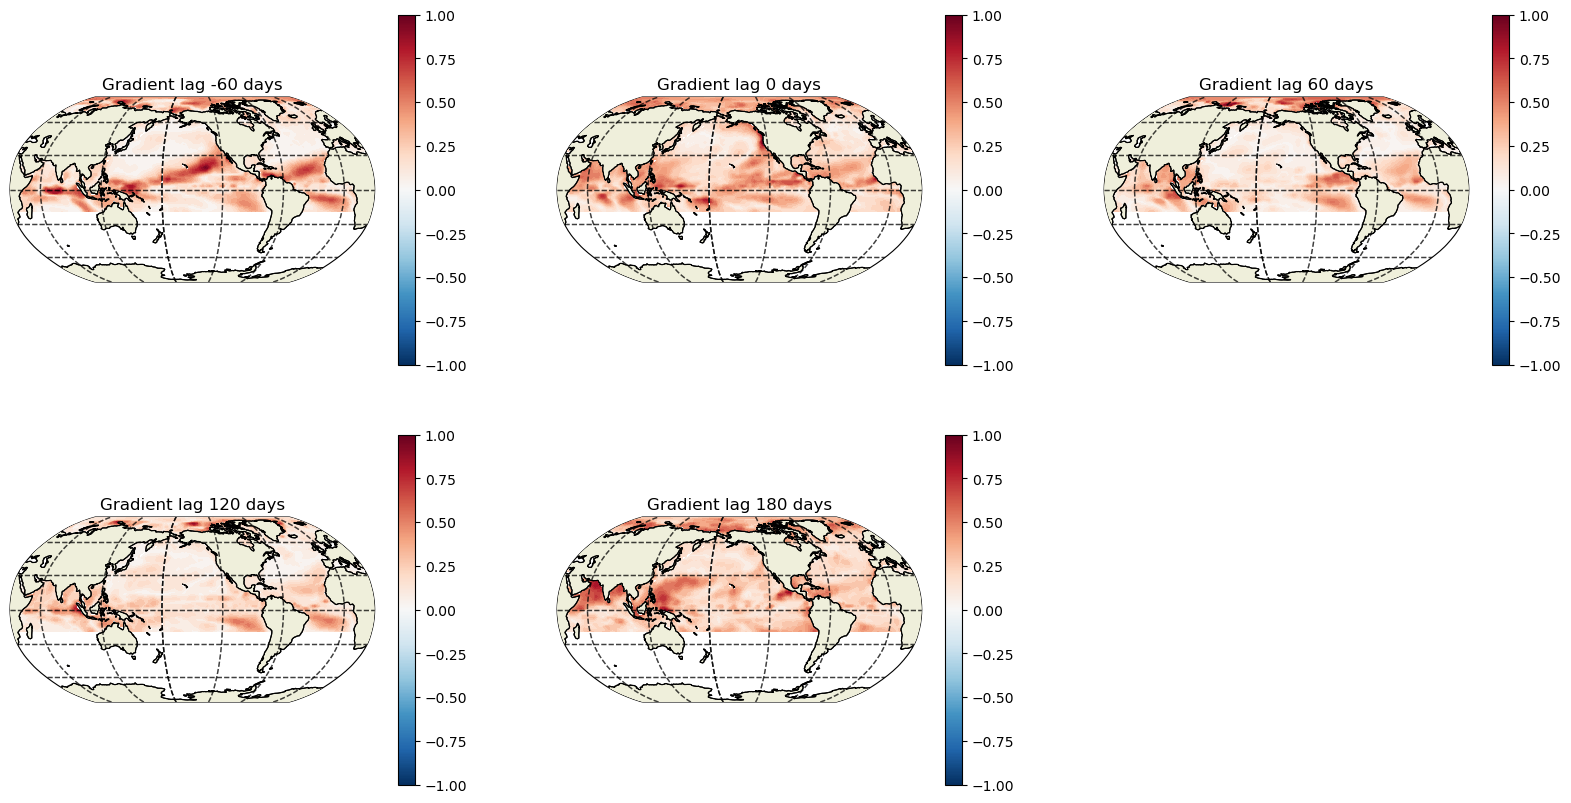

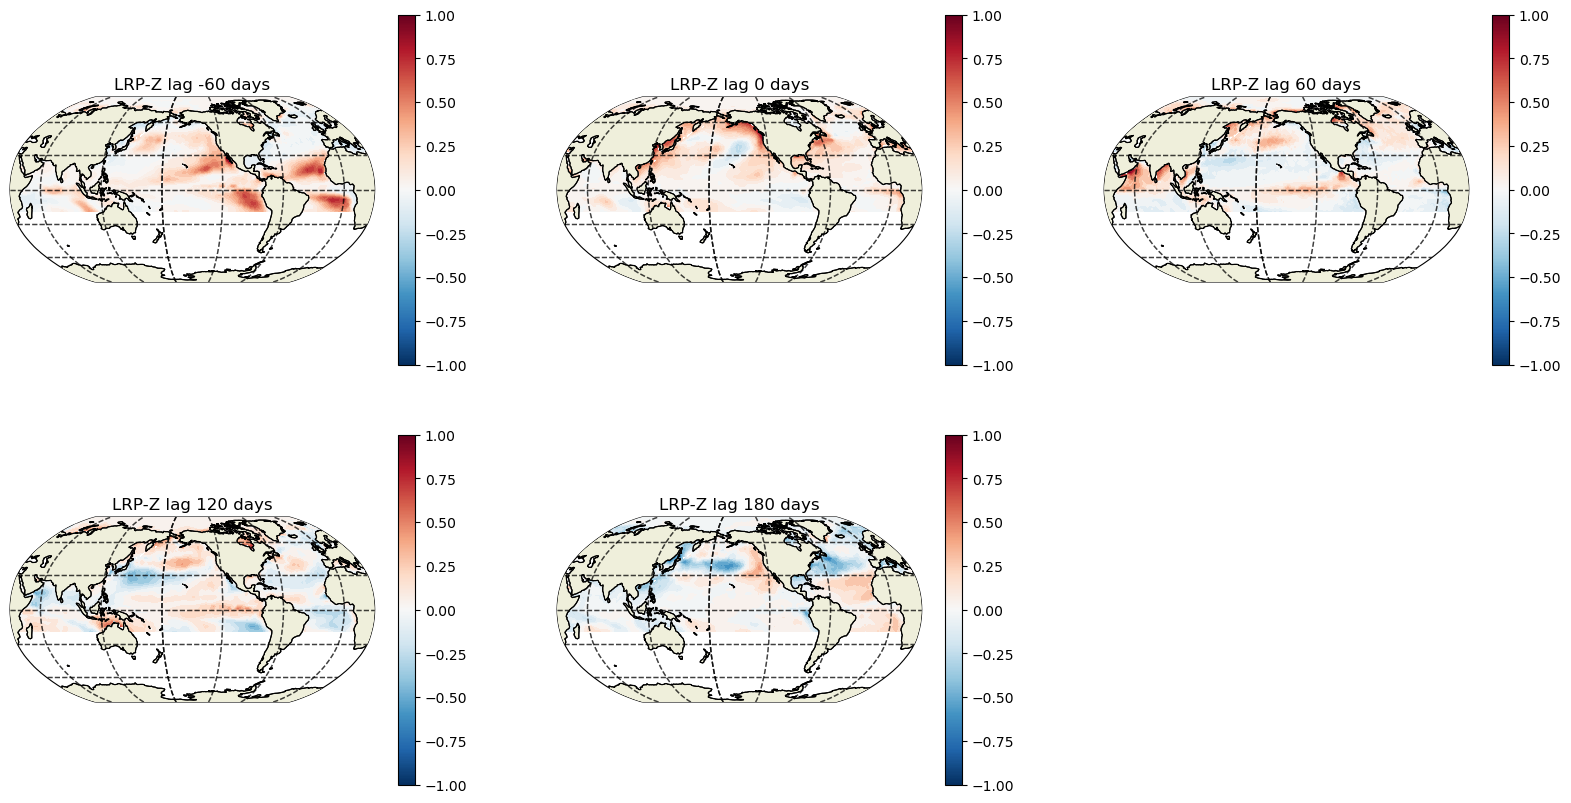

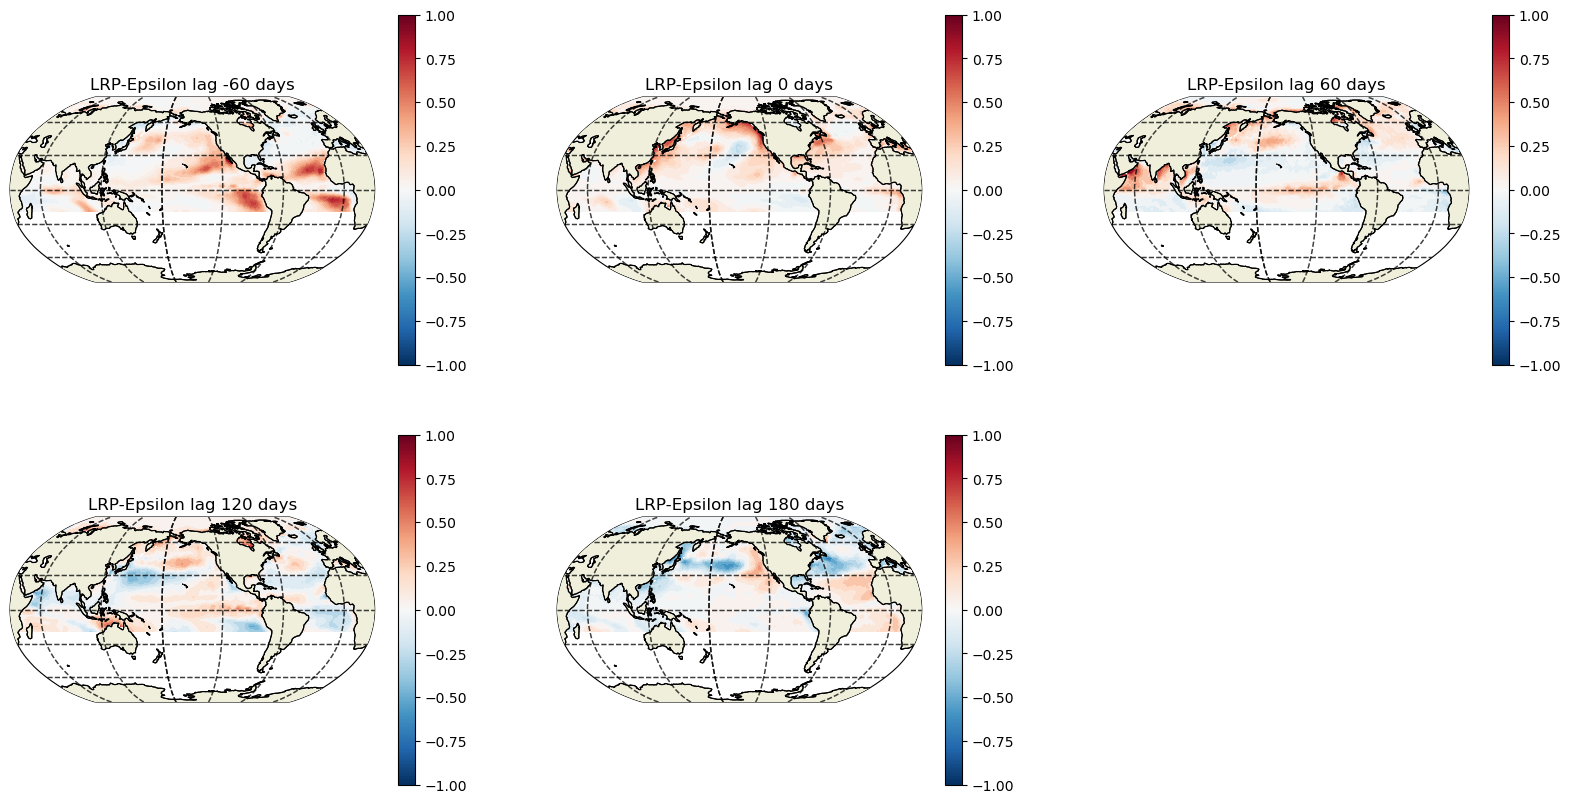

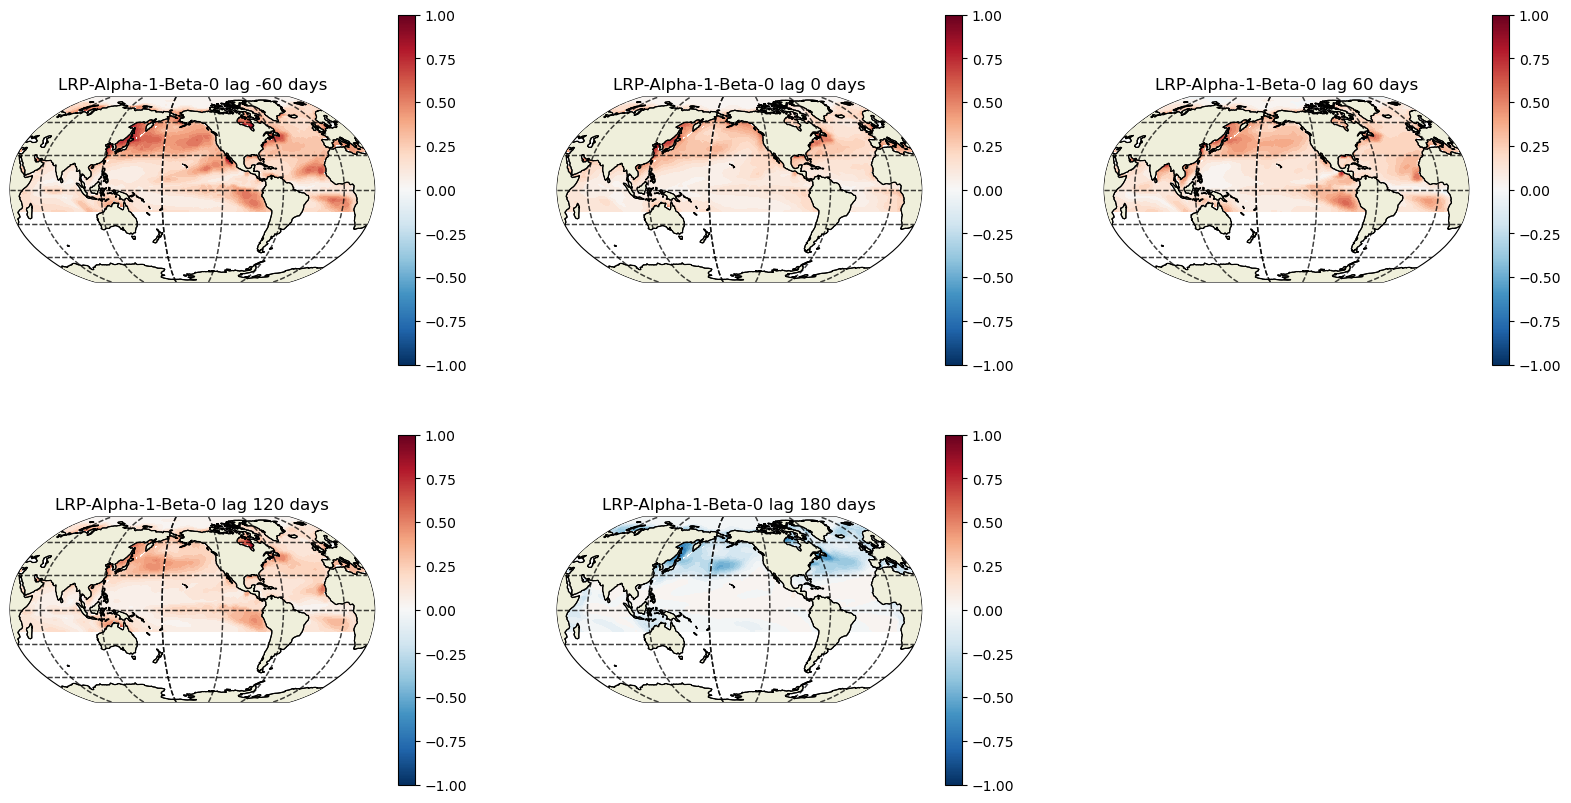

In [13]:
for method in methods:

    plt.rcParams["figure.figsize"] = (20,10)
    
    field = np.nanmean(LRPDict_theta['LRP-60'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  user_lon_0 = -150,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,1])
    
    P[1].set_title(f"{method['title']} lag -60 days")
    
    field = np.nanmean(LRPDict_theta['LRP0'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  user_lon_0 = -150,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,2])
    
    P[1].set_title(f"{method['title']} lag 0 days")
    
    field = np.nanmean(LRPDict_theta['LRP60'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  user_lon_0 = -150,
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,3])
    
    P[1].set_title(f"{method['title']} lag 60 days")
    
    field = np.nanmean(LRPDict_theta['LRP120'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  user_lon_0 = -150,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,4])
    
    P[1].set_title(f"{method['title']} lag 120 days")
    
    field = np.nanmean(LRPDict_theta['LRP180'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                  field,
                                  plot_type = 'contourf',
                                  show_colorbar=True, cmap='RdBu_r', cmin = -1, cmax = 1,
                                  user_lon_0 = -150,
                                  dx=2, dy=2, projection_type = 'robin',
                                  less_output = True, subplot_grid = [2,3,5])
    
    P[1].set_title(f"{method['title']} lag 180 days")
    
    field = np.nanmean(LRPDict_theta['LRP180'][method['name']], axis=(0,1))
    field = field / np.nanmax(np.abs(field))
    plt.show()